# Which SNOMED CT codes for HbA1c are useful?

The purpose of this notebook is to figure out which of the SNOMED CT codes that relate to HbA1c are useful for the study of HbA1c values.

The motivation for this purpose is that there are some strange results returned from a simple study of the numeric values that are returned from querying the [OpenSAFELY list of HbA1c SNOMED CT codes](https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests-numerical-value/). One would expect mmol/mol values between 40 and 80, typically, which approximately correspond to 5.8% to 9.5% in the percentage units. Instead, I am seeing values in the tens of thousands and values that are minus.

In this notebook, I want to see if the problems are arising because of particular SNOMED CT codes, and see if my script to identify and convert the old percentage units into mmol/mol is performing correctly.

(Note: The formula for converting the old percentage units to mmol/mol can be found, [here](https://ebmcalc.com/GlycemicAssessment.htm).)

### Set up.

In [77]:
if( !"pacman" %in% installed.packages() ){ install.packages( "pacman" ) }
pacman::p_load(
    bigrquery
    ,tidyverse
    )

# Setup connection to GCP.
project_id = "yhcr-prd-bradfor-bia-core"
con <- DBI::dbConnect( drv = bigquery(), project = project_id ) %>% suppressWarnings()

# Define R tibbles from GCP tables.
r_tbl_srcode <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srcode" )

# Define the list of SNOMED CT codes.
codes_SNOMED_test_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-glycated-haemoglobin-hba1c-tests-3e5b1269.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_diagnoses_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dmtype2_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_T1DM_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dmtype1_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code

### Histogram of HbA1c values less than 200.

In [81]:
# Make base dataset.
person_T2DM <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_diagnoses_of_interest ) %>%
    dplyr::distinct( person_id ) %>%
    dplyr::mutate( T2DM = 1 )
person_T1DM <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_T1DM_of_interest ) %>%
    dplyr::distinct( person_id ) %>%
    dplyr::mutate( T1DM = 1 )


dataset <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest ) %>%
    dplyr::select( person_id, numericvalue, snomedcode ) %>%
    dplyr::mutate( numericvalue = numericvalue %>% as.numeric() ) %>%
    dplyr::filter( numericvalue < 200 ) %>%
    dplyr::left_join(
        person_T2DM
        ,by = join_by( person_id )
    ) %>%
    dplyr::mutate( T2DM = dplyr::if_else( is.na( T2DM ), "No T2DM", "T2DM" ) ) %>%
    dplyr::left_join(
        person_T1DM
        ,by = join_by( person_id )
    ) %>%
    dplyr::mutate( T1DM = dplyr::if_else( is.na( T1DM ), "No T1DM", "T1DM" ) ) %>%
    dplyr::mutate(
        diabetes = dplyr::case_when(
            T2DM == "T2DM" ~ "T2DM"
            ,T1DM == "T1DM" ~ "T1DM"
            ,TRUE ~ "No diabetes"
        )
    )

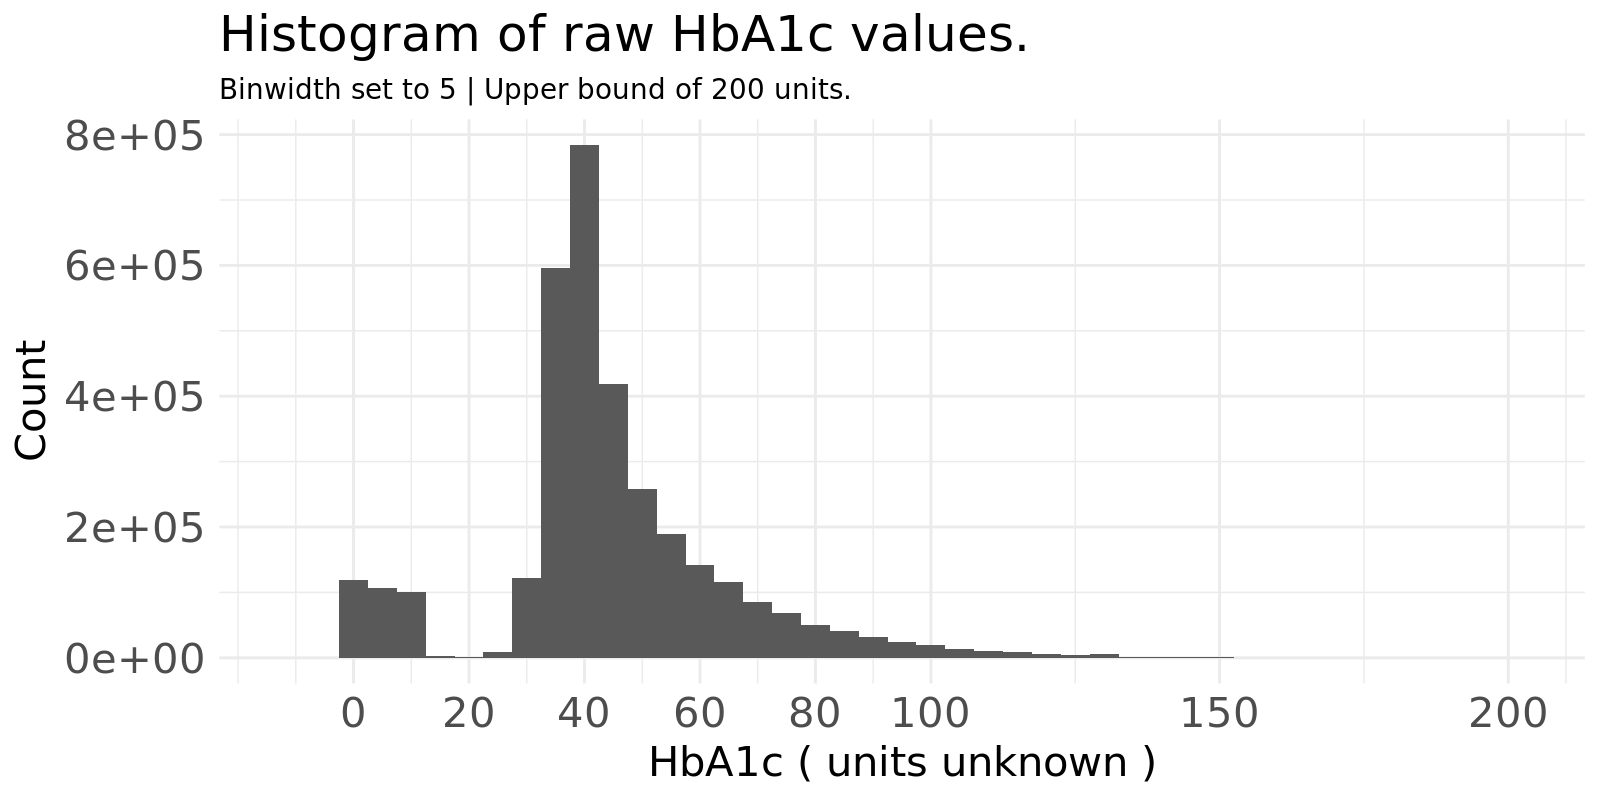

In [80]:
# Plot histogram.
options( repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200 )

dataset %>%
ggplot( aes( x = numericvalue ) ) +
geom_histogram( binwidth = 5 ) +
labs(
    title = "Histogram of raw HbA1c values."
    ,subtitle = "Binwidth set to 5 | Upper bound of 200 units."
    ,x = "HbA1c ( units unknown )"
    ,y = "Count"
) +
scale_x_continuous( breaks = c( seq( 0, 100, 20), 150, 200 ) ) +
theme_minimal() +
theme(
    title = element_text( size = 15 )
    ,plot.subtitle = element_text( size = 10 )
    ,axis.text = element_text( size = 15 )
)

There is an obvious mix of distributions, separated at 20 units. The right-side distribution seems to be mmol/mol units, while hte left-side distribution seems to be the old % units.

If I want to keep the old % units, the I need to apply a transformation to the values below 20.

Below, I show the distribution after I have applied the transformation, and reapplied the threshold of 20 mmol/mol.

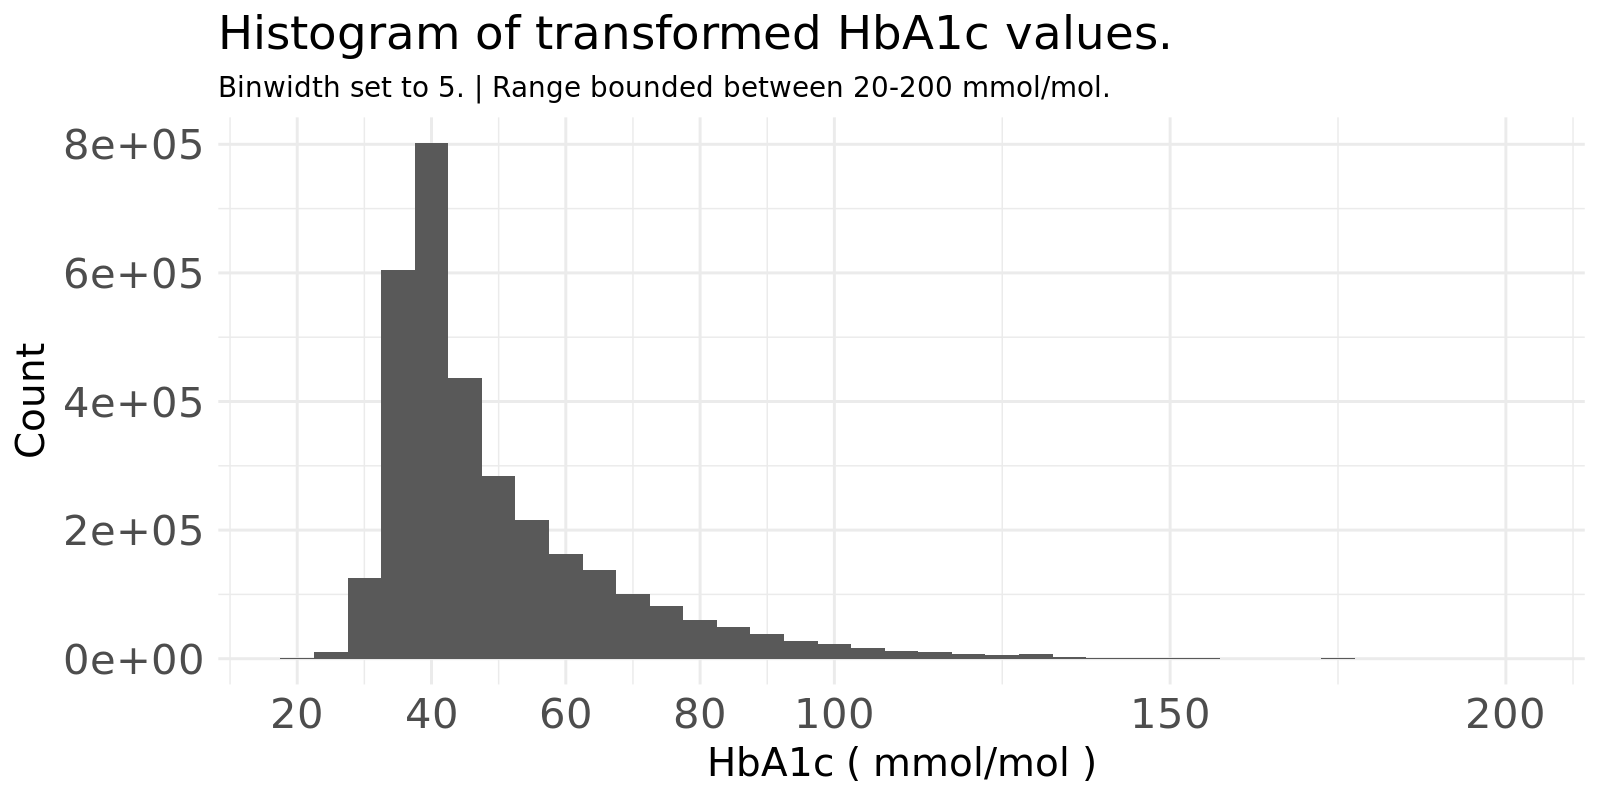

In [82]:
# Apply selective transformation.
dataset <-
    dataset %>%
    dplyr::filter(
        dplyr::case_when(
            snomedcode %in% codes_SNOMED_test_of_interest ~ numericvalue > 2.15
            ,.default = numericvalue == numericvalue
        )
    ) %>%         
    dplyr::mutate(
        numericvalue = 
            dplyr::if_else(
                ( snomedcode %in% codes_SNOMED_test_of_interest ) & ( numericvalue < 20 )
                ,( numericvalue %>% `-`( 2.15 ) ) %>% `*`( 10.929 )
                ,numericvalue
            )
    ) %>%
    dplyr::filter( ( numericvalue >= 20 ) | is.na( numericvalue ) )

# Plot histogram.
options( repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200 )

dataset %>%
ggplot( aes( x = numericvalue ) ) +
geom_histogram( binwidth = 5 ) +
labs(
    title = "Histogram of transformed HbA1c values."
    ,subtitle = "Binwidth set to 5. | Range bounded between 20-200 mmol/mol."
    ,x = "HbA1c ( mmol/mol )"
    ,y = "Count"
) +
scale_x_continuous( breaks = c( seq( 20, 100, 20), 150, 200 ) ) +
theme_minimal() +
theme(
    title = element_text( size = 14 )
    ,plot.subtitle = element_text( size = 10 )
    ,axis.text = element_text( size = 15 )
)

Everything looks to be reasonable in the histogram and most of the descripive summary statistics below look feasible for a general population who haven't been filtered for having a clinically-coded diagnosis of T2DM. The exception are the minimum values that are artificially bounded at 20 mmol/mol.

In [63]:
# Provide descriptive statistics of each SNOMED code.
dataset %>%
dplyr::collect() %>%
dplyr::group_by( snomedcode ) %>%
dplyr::summarise(
    n = n()
    ,max = max( numericvalue )
    ,mean = mean( numericvalue )
    ,median = numericvalue %>% quantile( 0.5 )
    ,min = min( numericvalue )
) %>%
dplyr::ungroup()

snomedcode,n,max,mean,median,min
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1003671000000109,209575,185.2466,61.67562,58.47015,20
1049301000000100,3922,173.2246,51.41891,43.00000,20
999791000000106,3010362,199.0000,48.66978,42.00000,20


I stratify the results by a factor indicating whether the patient record contains a diagnostic code for Type 1 Diabetes Mellitus, Type 2 Diabetes Mellitus, or no record for either. As expected, those records with a clinical code for diabetes show larger values for HbA1c. Records with a code for T1DM show a higher distribution than for T2DM, but T2DM have a larger spread.

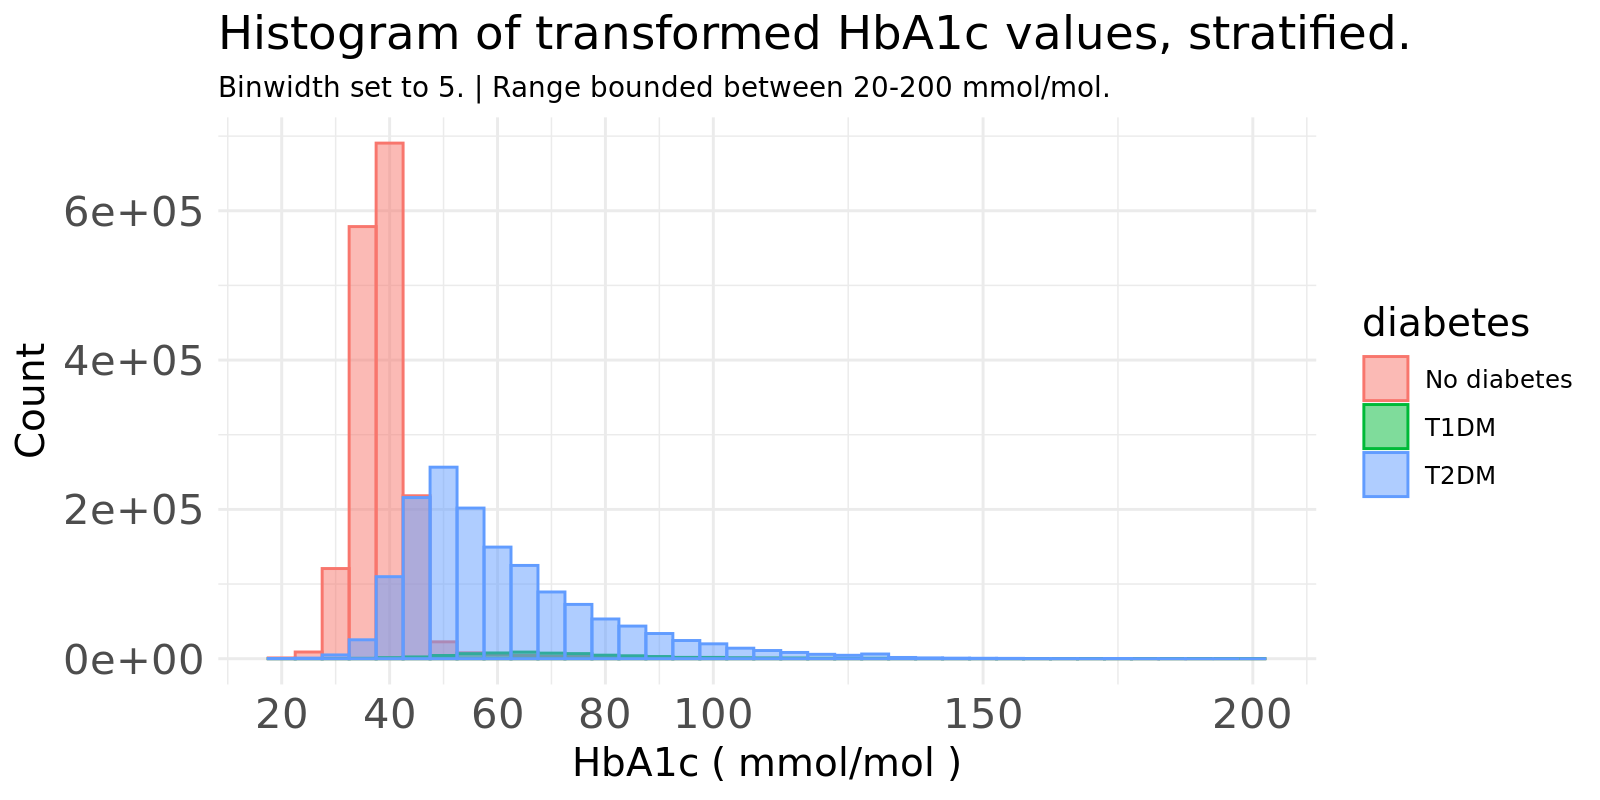

In [89]:
# Plot histogram.
options( repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200 )

dataset %>%
ggplot( aes( x = numericvalue, group = diabetes, colour = diabetes, fill = diabetes ) ) +
geom_histogram( binwidth = 5, alpha = 0.5, position = "identity" ) +
labs(
    title = "Histogram of transformed HbA1c values, stratified."
    ,subtitle = "Binwidth set to 5. | Range bounded between 20-200 mmol/mol."
    ,x = "HbA1c ( mmol/mol )"
    ,y = "Count"
) +
scale_x_continuous( breaks = c( seq( 20, 100, 20), 150, 200 ) ) +
theme_minimal() +
theme(
    title = element_text( size = 14 )
    ,plot.subtitle = element_text( size = 10 )
    ,axis.text = element_text( size = 15 )
)

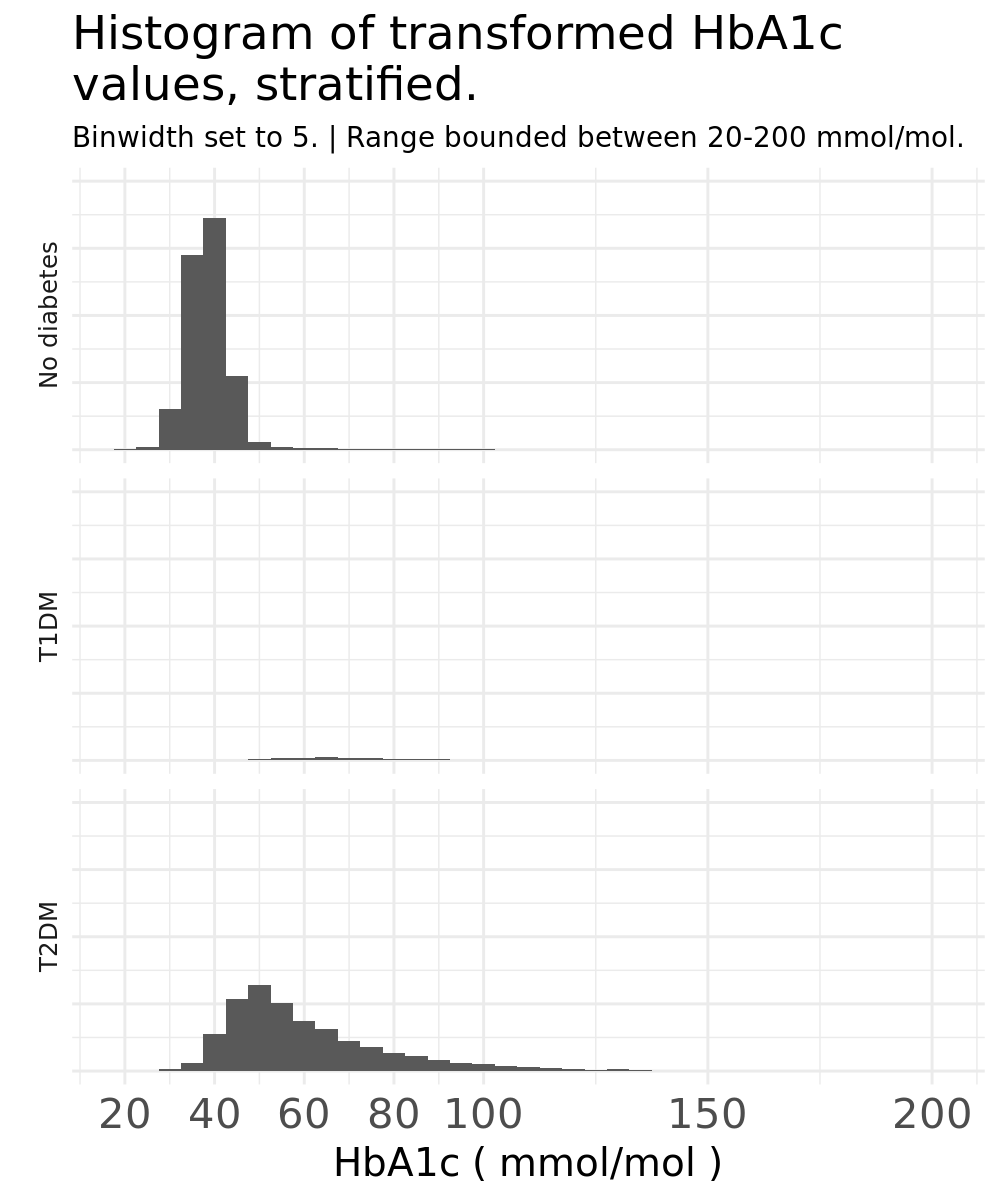

In [88]:
# Plot histogram.
options( repr.plot.width = 5, repr.plot.height = 6, repr.plot.res = 200 )

dataset %>%
ggplot( aes( x = numericvalue ) ) +
geom_histogram( binwidth = 5 ) +
labs(
    title = "Histogram of transformed HbA1c\nvalues, stratified."
    ,subtitle = "Binwidth set to 5. | Range bounded between 20-200 mmol/mol."
    ,x = "HbA1c ( mmol/mol )"
    ,y = "Count"
) +
facet_grid( rows = vars( diabetes ), switch = "y" ) + 
scale_x_continuous( breaks = c( seq( 20, 100, 20), 150, 200 ) ) +
ylim( 0, 8e5) +
theme_minimal() +
theme(
    title = element_text( size = 14 )
    ,plot.subtitle = element_text( size = 10 )
    ,axis.text = element_text( size = 15 )
    ,axis.text.y = element_blank()
    ,axis.title.y = element_blank()
)

In [85]:
# Provide descriptive statistics of each SNOMED code.
dataset %>%
dplyr::collect() %>%
dplyr::group_by( diabetes, snomedcode ) %>%
dplyr::summarise(
    n = n()
    ,max = max( numericvalue )
    ,mean = mean( numericvalue )
    ,median = numericvalue %>% quantile( 0.5 )
    ,min = min( numericvalue )
) %>%
dplyr::ungroup()

`summarise()` has grouped output by 'diabetes'. You can override using the
`.groups` argument.


diabetes,snomedcode,n,max,mean,median,min
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
No diabetes,1003671000000109,16360,176.5034,48.56127,40.98375,20.21865
No diabetes,1049301000000100,2298,99.0000,39.36492,38.00000,21.00000
No diabetes,999791000000106,1656124,186.0000,38.80098,38.00000,20.00000
T1DM,1003671000000109,19406,180.8750,71.05787,68.30625,20.00000
T1DM,1049301000000100,200,115.0000,58.28000,57.00000,25.00000
T1DM,999791000000106,47385,199.0000,72.63906,69.00000,20.00000
T2DM,1003671000000109,173809,185.2466,61.86248,58.47015,20.21865
T2DM,1049301000000100,1424,173.2246,69.90757,62.00000,20.00000
T2DM,999791000000106,1306853,192.8969,60.30703,55.00000,20.00000


The new scripting rules provide sensible results. I will incorporate this into the `RESHAPE_cohort_generator.r` script.